In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import os.path as path
import copy
# from torch.utils.data.sampler import SequentialSampler


from gait_analysis import AnnotationsCasia as Annotations
from gait_analysis import CasiaDataset
from gait_analysis.Config import Config
from gait_analysis import Composer

import matplotlib.pyplot as plt

print("done")

done


In [2]:
#change configuration in settings.py

crop_im_size = [186,250]
c = Config()
c.config['indexing']['grouping'] = 'person_sequence_angle'
c.config['indexing']['people selection'] = [1]
#c.config['indexing']['sequences_selection'] = ['nm-01']
c.config['pose']['load'] = False
c.config['flow']['load'] = True
c.config['heatmaps']['load'] = False
#c.config['scenes']['sequences'] = ['nm']
#c.config['scenes']['angles'] = ['108']
c.config['dataset_output'] = {
#         'data': ["scenes","flows","heatmaps_LAnkle","heatmaps_RAnkle"],
        'data': ["flows"],
        'label': "annotations"}
composer = Composer()
transformer = composer.compose()
dataset = CasiaDataset(transform=transformer)

loading configuration  flows
[OK]


## NETWORK AND DATASET PARAMETERS

In [3]:
#DESIGN PARAMETERS FOR NEURAL NETWORK
NR_LSTM_UNITS = 2 
IMAGE_INPUT_SIZE_W = 640
IMAGE_INPUT_SIZE_H = 480

IMAGE_AFTER_CONV_SIZE_W = 18
IMAGE_AFTER_CONV_SIZE_H = 13
#for 3x3 kernels, n=num_layers: len_in = 2^n*len_out + sum[i=1..n](2^i)
#CONV_LAYER_LENGTH = 5

LSTM_IO_SIZE = 18*13
LSTM_HIDDEN_SIZE = 18*13

RGB_CHANNELS = 3
TIMESTEPS = 10 # size videos
BATCH_SIZE = 1 #until now just batch_size = 1

NR_EPOCHS = 50

VALIDATION_SPLIT = 0.2
RANDOMIZED_SEED = 10
SHUFFLE_DATASET = False

learning_rate = 0.01 # reduce factos of 10 .. some epoch later.
momentum = 0.9
print("Hyperparameters defined")

Hyperparameters defined


# Settings 
## Dataset

In [4]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
print("Dataset size:", len(dataset))
print("Indices size:", len(indices))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))
print("Split:", split)
if SHUFFLE_DATASET:
    np.random.seed(RANDOMIZED_SEED)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_sampler = torch.utils.data.SequentialSampler(train_indices)
test_sampler = torch.utils.data.SequentialSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# #

Dataset size: 280
Indices size: 280
Split: 56


## neural network

In [5]:

#USE RANDOM IMAGES TO SET UP WORKING EXAMPLE
class TEST_CNN_LSTM(nn.Module):
    def __init__(self):
        super(TEST_CNN_LSTM, self).__init__()
        self.avialable_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.conv1 = nn.Conv2d(3,6,3) #input 640x480
        self.pool1 = nn.MaxPool2d(2,2) #input 638x478 output 319x239
        self.conv2 = nn.Conv2d(6,16,3) # input 319x239 output 317x237
        self.pool2 = nn.MaxPool2d(2,2) # input 317x237 output 158x118
        self.conv3 = nn.Conv2d(16,6,3) # input 158x118 output 156x116
        self.pool3 = nn.MaxPool2d(2,2) # input 156x116 output 78x58
        self.conv4 = nn.Conv2d(6,3,3)  # input 78x58 output 76x56
        self.pool4 = nn.MaxPool2d(2,2) # input 76x56 output 39x29
        self.conv5 = nn.Conv2d(3,1,3)  # input 39x29 output 37x27
        self.pool5 = nn.MaxPool2d(2,2) #output 37x27 output 18x13
        self.lstm1 = nn.LSTM(LSTM_IO_SIZE,
                            LSTM_HIDDEN_SIZE,
                            TIMESTEPS)# horizontal direction
        self.lstm2 = nn.LSTM(LSTM_IO_SIZE,
                            LSTM_HIDDEN_SIZE,
                            TIMESTEPS)# horizontal direction
        self.fc1 = nn.Linear(LSTM_IO_SIZE,120)
        self.fc2 = nn.Linear(120,20)
        self.fc3 = nn.Linear(20,3)
        
        #initialize hidden states of LSTM
        self.hidden = self.init_hidden()

        #print("Hidden:", _hidden)
    def init_hidden(self):
        return (torch.randn(TIMESTEPS, BATCH_SIZE, LSTM_HIDDEN_SIZE).to(self.avialable_device), 
                torch.randn(TIMESTEPS, BATCH_SIZE, LSTM_HIDDEN_SIZE).to(self.avialable_device))
    def forward(self,x):
#         print("Input list len:",len(x))
#         print("Input elemens size:", x[0].size())
#         batch_size = x[0].size()[0]

        x_arr = torch.zeros(TIMESTEPS,BATCH_SIZE,1,IMAGE_AFTER_CONV_SIZE_H,IMAGE_AFTER_CONV_SIZE_W).to(self.avialable_device)
        ## print("X arr size", x_arr.size())
        for i in range(TIMESTEPS):#parallel convolutions which are later concatenated for LSTM
            x_tmp_c1 = self.pool1(F.relu(self.conv1(x[i].float())))
            x_tmp_c2 = self.pool2(F.relu(self.conv2(x_tmp_c1)))
            x_tmp_c3 = self.pool3(F.relu(self.conv3(x_tmp_c2)))
            x_tmp_c4 = self.pool4(F.relu(self.conv4(x_tmp_c3)))
            x_tmp_c5 = self.pool5(F.relu(self.conv5(x_tmp_c4)))
            x_arr[i] = x_tmp_c5 # torch.squeeze(x_tmp_c5)
        
        x, hidden = self.lstm1(x_arr.view(TIMESTEPS,BATCH_SIZE,-1), self.hidden)
        x, hidden = self.lstm2(x, self.hidden)
        # the reshaping was taken from the documentation... and makes scense
        x = x.view(TIMESTEPS,BATCH_SIZE,LSTM_HIDDEN_SIZE) #output.view(seq_len, batch, num_dir*hidden_size)
#         x = torch.squeeze(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        x = x.squeeze(1)
        #x = x.permute(1,2,0)
        return x
print("Class defined")

Class defined


In [6]:
# TODOS:
# Look for overfitting..
# use GPU: 300 samples. many epochs. learning rate maybe is too high.
# Tweak learning rate
# Increase the RNN size
# Maybe change the CNN
# Use patches. or OF
# Increase the dataset: 10 images 10peoplo+++ not too much too much variance. 
# FEEDBACK on friday..:) 

### Test-Training

In [7]:
#TRAINING
test_net = TEST_CNN_LSTM()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
test_net.to(device)
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
optimizer = optim.SGD(test_net.parameters(), lr=learning_rate, momentum=momentum)


cuda:0


In [8]:
### define and execute testing function
def test_all_preds(model):
    n_batches_test = len(test_loader)

    #Time for printing
    testing_start_time = time.time()

    print('Start testing...')
    correct = 0 
    total = 0
    with torch.no_grad():
        for i, batch in enumerate(train_loader):
            inputs, labels = batch
            
            in_data = [s.to(device) for s in inputs['flows']]
            labels = labels.to(device)
            if not labels.size()[0] == BATCH_SIZE:
                # skip uncompleted batch size NN is fixed to BATCHSIZE
                continue
            outputs = model(in_data)
#             print("Out:", len(outputs), outputs.size())
#             print("Labels:", len(labels), labels.size())
            _, predicted = torch.max(outputs.data, 1)
#             print('predicted:',len(predicted),predicted.size())
            n_errors = torch.nonzero(torch.abs(labels.long() - predicted)).size(0)
            total += predicted.numel()
            # print('predicted',predicted)
            correct += predicted.numel() - n_errors
            # print('labels',labels)
    print('Accuracy {:.2f}%'.format(100*correct/total))
    print('...testing finished')


### training over all predictions

Starting
Start training.. on decive:. cuda:0
Epoch: 0


/home/ron/anaconda3/envs/gait_37/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Loss epoch 0: 242.08396688103676, took 248.3731644153595s
Epoch: 1
Loss epoch 1: 247.4280228316784, took 225.25541996955872s
Epoch: 2
Loss epoch 2: 248.36431312561035, took 219.2574381828308s
Epoch: 3
Loss epoch 3: 243.1202556490898, took 218.80188131332397s
Epoch: 4
Loss epoch 4: 241.03132048249245, took 230.55708861351013s
Epoch: 5
Loss epoch 5: 238.39883443713188, took 218.69959020614624s
Epoch: 6
Loss epoch 6: 237.12934082746506, took 218.6083676815033s
Epoch: 7
Loss epoch 7: 236.8548187315464, took 219.1582190990448s
Epoch: 8
Loss epoch 8: 237.52471733093262, took 220.64504170417786s
Epoch: 9
Loss epoch 9: 238.526391685009, took 217.38041400909424s
Epoch: 10
Loss epoch 10: 238.24408730864525, took 218.03436827659607s
Epoch: 11
Loss epoch 11: 238.03823429346085, took 219.9861614704132s
Epoch: 12
Loss epoch 12: 237.47585907578468, took 218.36461758613586s
Epoch: 13
Loss epoch 13: 237.29656225442886, took 218.44953894615173s
Epoch: 14
Loss epoch 14: 238.10351088643074, took 219.09758

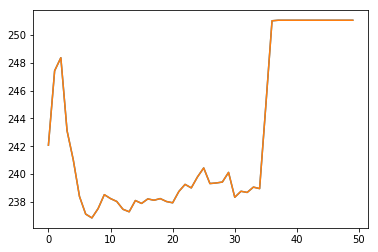

In [9]:
print("Starting")
n_batches = len(train_loader)

#Time for printing
training_start_time = time.time()

loss_array = np.zeros(NR_EPOCHS)

print('Start training.. on decive:.',device)
for epoch in range(NR_EPOCHS): 
    running_loss = 0.0
    start_time = time.time()
    total_train_loss = 0
    
    print("Epoch:", epoch)
    running_loss = 0.0
    for i, batch in enumerate(train_loader): #loads all angles
        inputs, labels = batch
        in_data = [s.to(device) for s in inputs['flows']]
        labels = labels.permute(1,0).to(device)
        #if not labels.size()[0] == BATCH_SIZE:
        #    # skip uncompleted batch size NN is fixed to BATCHSIZE
        #    continue
        optimizer.zero_grad() 
        outputs = test_net(in_data)
        labels = labels.squeeze(1)
        #print("Out:", len(outputs), outputs.size())
        #print("Out content:", outputs)
        #print("Labels:", len(labels), labels.size())
        #print("Labels content:", labels)
        
        #print(scenes[0].squeeze(0).permute(2,1,0).size())
        #for j in range(10):
        #    scene_print = scenes[j].squeeze(0).permute(1,2,0)
        #    plt.imshow(scene_print.numpy())
        #    plt.show()
        #print(labels)
        loss = criterion(outputs,labels.long())
        loss.backward() 
        optimizer.step()
        
        #Print statistics
        # print(loss.data.item())
        running_loss += loss.data.item()
        #total_train_loss += loss.data.item()
        
        #Print every 10th batch of an epoch
#         if (i + 1) % (print_every + 1) == 0:
#             print("Epoch {}, {:d}% \t train_loss(mean): {:.2f} took: {:.2f}s".format(
#                     epoch+1, int(100 * (i+1) / n_batches), running_loss/print_every, time.time() - start_time))
#             #Reset running loss and time
#             running_loss = 0.0
#             start_time = time.time()
    # test after each epoch
    print("Loss epoch {}: {}, took {}s".format(epoch, running_loss,time.time()-start_time))
    loss_array[epoch] = running_loss

test_all_preds(test_net)
#print('total training loss for epoch {}: {:.6f}'.format(epoch+1, total_train_loss))    
print('...Training finished')
plt.plot(loss_array)
plt.plot(loss_array)


In [10]:
# print(labels.size())
# print(outputs.size())
# print(labels)
# print(outputs)
# import matplotlib.pyplot as plt
# print(scenes[0].squeeze(0).size())
# plt.imshow(scenes[9].squeeze(0).permute(1,2,0))
# plt.figure(figsize=(30,40))
# print('left foot trans from air to ground')
# plt.subplot(131)
# plt.imshow(scenes[4])
# plt.title('frame 44')
# plt.subplot(132)
# plt.imshow(scenes[5])
# plt.title('frame 45')
# plt.subplot(133)
# plt.imshow(scenes[6])
# plt.title('frame 46')
# plt.show()
